In [2]:
%load_ext autoreload
%autoreload 2
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import sys
sys.path.append('../../../src/benchmark/')
sys.path.append('../../../src/utils/')
from build_model import resnet50_, densenet161_, fpn_resnet50_classification, xcit_small
from utils import hdf5_dataset, list_to_dict, viz_dataloader
from prediction_analysis import confusion_matrix, plot_cm, prediction_vs_actual, most_confused, show_cm

NAME = '01102024-benchmark-resnet50_from_scratch-v4_10m'

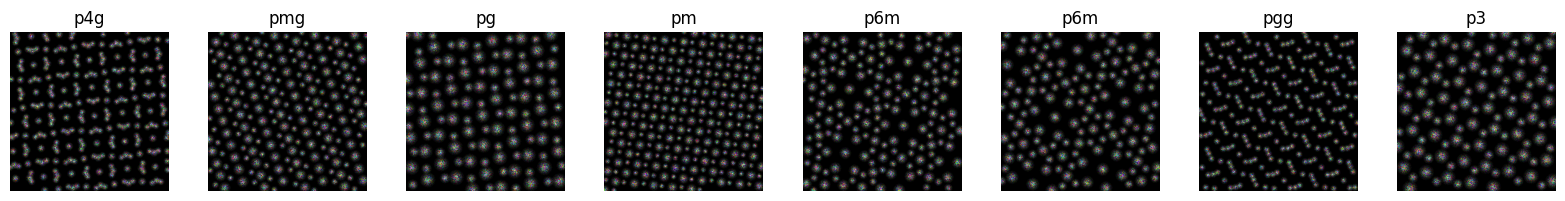

In [5]:
symmetry_classes = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']
label_converter = list_to_dict(symmetry_classes)

cv_atom_noised_ds = hdf5_dataset('../../../datasets/atom_noised_v4_rot_500K.h5', folder='test', transform=transforms.ToTensor())
cv_atom_noised_dl = DataLoader(cv_atom_noised_ds, batch_size=1028, shuffle=False, num_workers=2)
viz_dataloader(cv_atom_noised_dl, label_converter=label_converter)

In [4]:
model = torch.load('../../../saved_models/05312023-benchmark-resnet50_from_scratch-v4_10m-epoch-20.pt')
device = torch.device('cuda:1')

In [6]:
cm = confusion_matrix(model, cv_atom_noised_dl, symmetry_classes, device, n_batches='all')
np.save(f'../../../saved_results/Benchmark/ResNet50/{NAME}-cv_atom_noised_cm.npy', cm)

100%|██████████| 469/469 [04:52<00:00,  1.60it/s]

Sum for true labels:


p1       p2       pm       pg       cm      pmm      pmg      pgg  \
0  28320.0  28320.0  28320.0  28320.0  28320.0  28320.0  28320.0  28320.0   

       cmm       p4      p4m      p4g       p3     p3m1     p31m       p6  \
0  28320.0  28320.0  28320.0  28320.0  28320.0  28320.0  28320.0  28320.0   

       p6m  
0  28320.0

Accuracy for these batches: 52.82652043868394%


printing set for seaborn


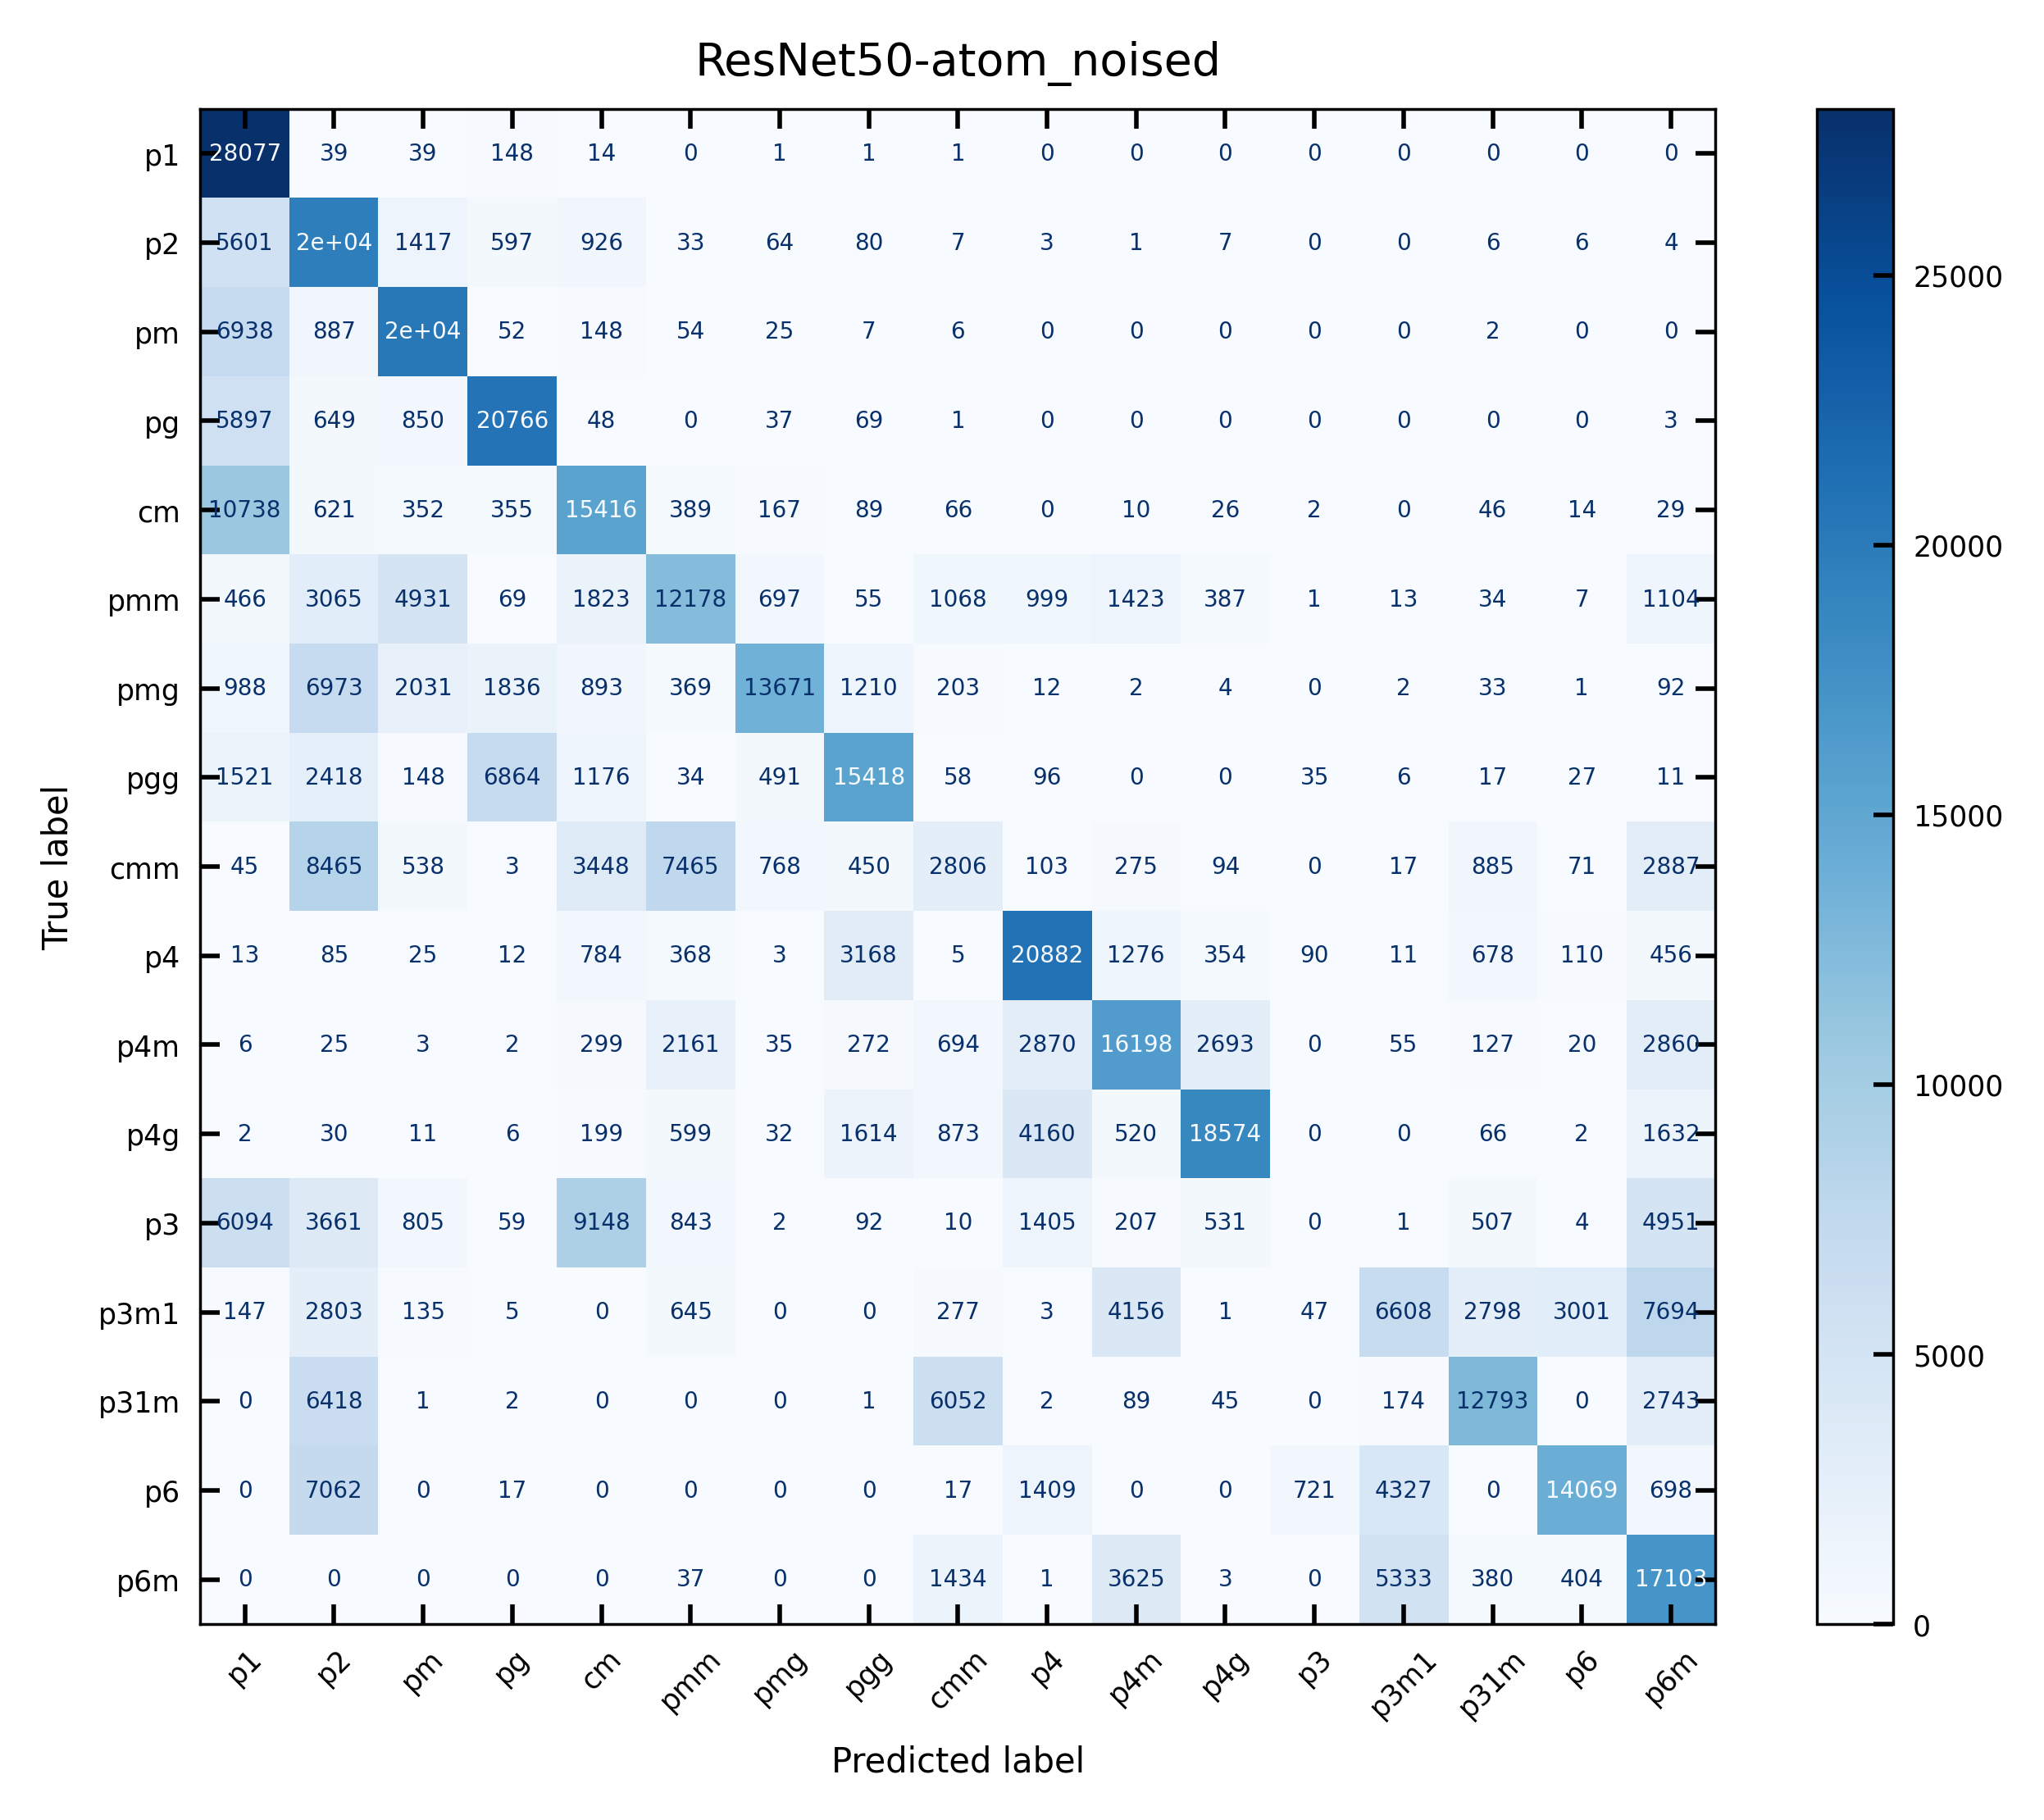

In [7]:
plot_cm(cm, symmetry_classes, title='ResNet50-atom_noised', cm_style='simple', fig_style='printing', font_size=4)

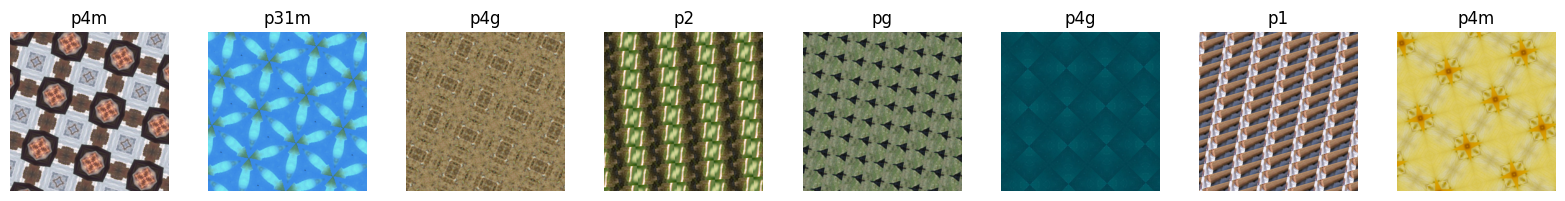

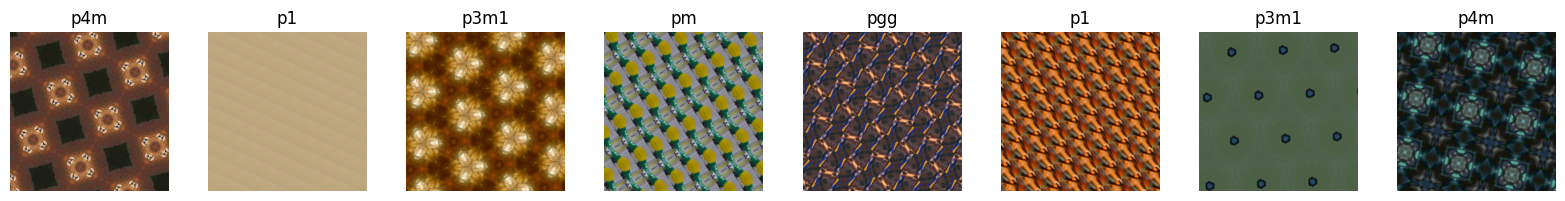

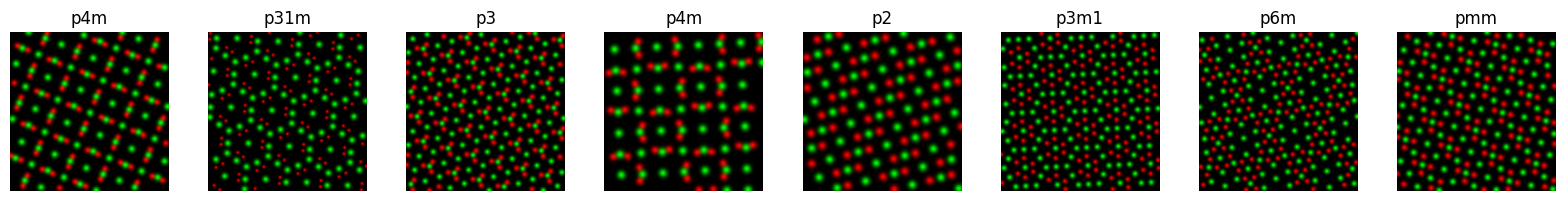

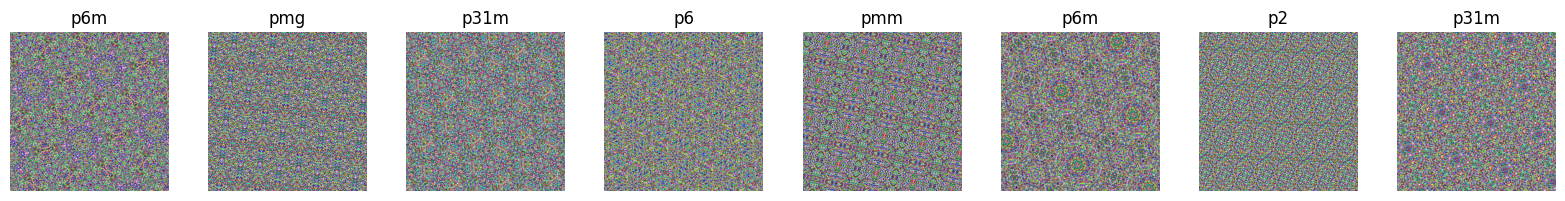

In [2]:
symmetry_classes = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']
label_converter = list_to_dict(symmetry_classes)

# imagenet
train_ds = hdf5_dataset('../../../datasets/imagenet_v4_rot_10m_train_unchunked.h5', folder='train', transform=transforms.ToTensor())
train_dl = DataLoader(train_ds, batch_size=1028, shuffle=False, num_workers=2)
viz_dataloader(train_dl, label_converter=label_converter)

valid_ds = hdf5_dataset('../../../datasets/imagenet_v4_rot_2m_valid_unchunked.h5', folder='valid', transform=transforms.ToTensor())
valid_dl = DataLoader(valid_ds, batch_size=1028, shuffle=False, num_workers=2)
viz_dataloader(valid_dl, label_converter=label_converter)

cv_atom_ds = hdf5_dataset('../../../datasets/atom_v4_rot_2m_unchunked.h5', folder='test', transform=transforms.ToTensor())
cv_atom_dl = DataLoader(cv_atom_ds, batch_size=1028, shuffle=False, num_workers=2)
viz_dataloader(cv_atom_dl, label_converter=label_converter)

cv_noise_ds = hdf5_dataset('../../../datasets/noise_v4_rot_2m-test.h5', folder='test', transform=transforms.ToTensor())
cv_noise_dl = DataLoader(cv_noise_ds, batch_size=1028, shuffle=False, num_workers=2)
viz_dataloader(cv_noise_dl, label_converter=label_converter)

In [3]:
model = fpn_resnet50_classification(in_channels=3, n_classes=17)

model = torch.load('../../../saved_models/05312023-benchmark-resnet50_from_scratch-v4_10m-epoch-20.pt')
device = torch.device('cuda:1')

### generate confusion matrix

In [4]:
cm = confusion_matrix(model, train_dl, symmetry_classes, device, n_batches='all')
np.save(f'../../../saved_results/Benchmark/ResNet50/{NAME}-train_imagenet_cm.npy', cm)

cm = confusion_matrix(model, valid_dl, symmetry_classes, device, n_batches='all')
np.save(f'../../../saved_results/Benchmark/ResNet50/{NAME}-valid_imagenet_cm.npy', cm)

cm = confusion_matrix(model, cv_atom_dl, symmetry_classes, device, n_batches='all')
np.save(f'../../../saved_results/Benchmark/ResNet50/{NAME}-cv_atom_cm.npy', cm)

cm = confusion_matrix(model, cv_noise_dl, symmetry_classes, device, n_batches='all')
np.save(f'../../../saved_results/Benchmark/ResNet50/{NAME}-cv_noise_cm.npy', cm)

  0%|          | 0/9728 [00:00<?, ?it/s]

  0%|          | 20/9728 [00:16<1:39:34,  1.62it/s]

### visualize confusions 

In [5]:
files = glob.glob(f'../../../saved_results/Benchmark/ResNet50/*')
files

['../../../saved_results/Benchmark/ResNet50/01102024-benchmark-resnet50_from_scratch-v4_10m-train_imagenet_cm.npy',
 '../../../saved_results/Benchmark/ResNet50/01102024-benchmark-resnet50_from_scratch-v4_10m-cv_noise_cm.npy',
 '../../../saved_results/Benchmark/ResNet50/01102024-benchmark-resnet50_from_scratch-v4_10m-cv_atom_cm.npy',
 '../../../saved_results/Benchmark/ResNet50/01102024-benchmark-resnet50_from_scratch-v4_10m-valid_imagenet_cm.npy',
 '../../../saved_results/Benchmark/ResNet50/01102024-benchmark-resnet50_from_scratch-v4_10m-cv_atom_noised_cm.npy']

In [8]:
for file in files:
    print(file)
    cm = np.load(file)
    accuracy = np.trace(cm) / np.sum(cm)
    print(f"Accuracy: {accuracy * 100:.2f}%\n")

    # plot_cm(cm, symmetry_classes, title=file.split('/')[-1].split('.')[0], cm_style='simple', fig_style='printing', font_size=4)

../../../saved_results/Benchmark/ResNet50/01102024-benchmark-resnet50_from_scratch-v4_10m-train_imagenet_cm.npy
Accuracy: 99.96%

../../../saved_results/Benchmark/ResNet50/01102024-benchmark-resnet50_from_scratch-v4_10m-cv_noise_cm.npy
Accuracy: 94.86%

../../../saved_results/Benchmark/ResNet50/01102024-benchmark-resnet50_from_scratch-v4_10m-cv_atom_cm.npy
Accuracy: 57.93%

../../../saved_results/Benchmark/ResNet50/01102024-benchmark-resnet50_from_scratch-v4_10m-valid_imagenet_cm.npy
Accuracy: 99.91%

../../../saved_results/Benchmark/ResNet50/01102024-benchmark-resnet50_from_scratch-v4_10m-cv_atom_noised_cm.npy
Accuracy: 52.83%



printing set for seaborn


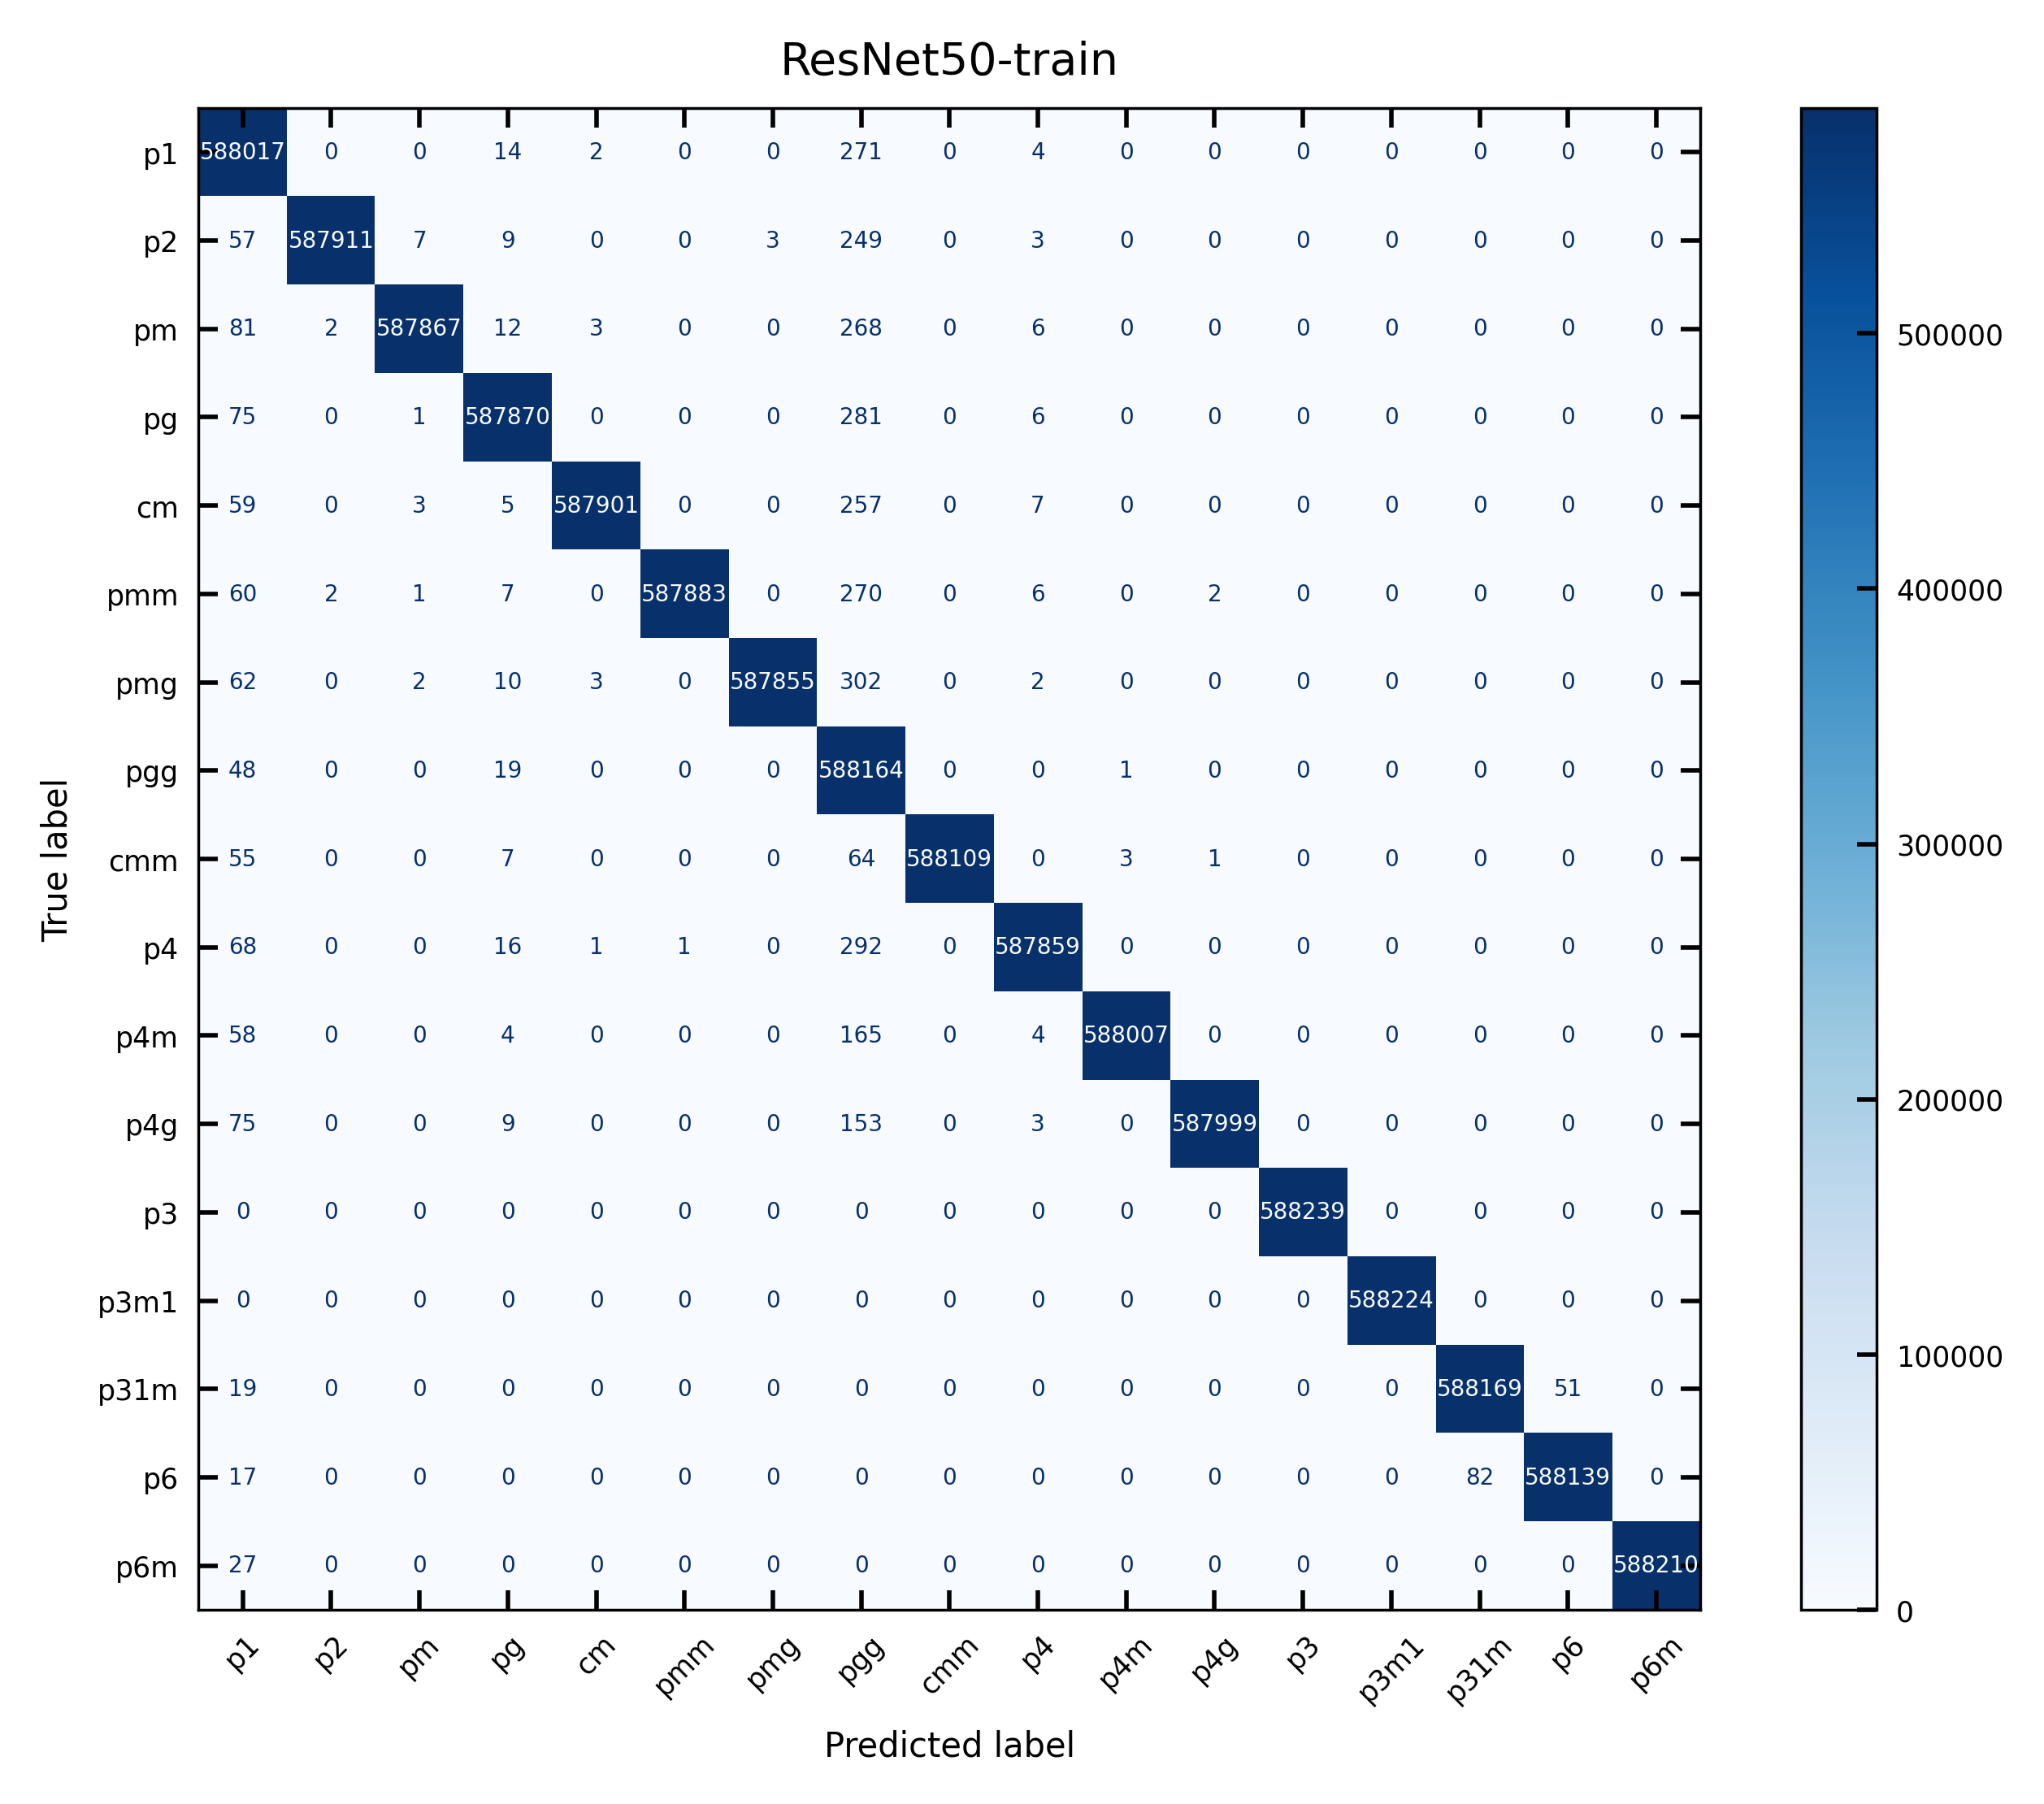

printing set for seaborn


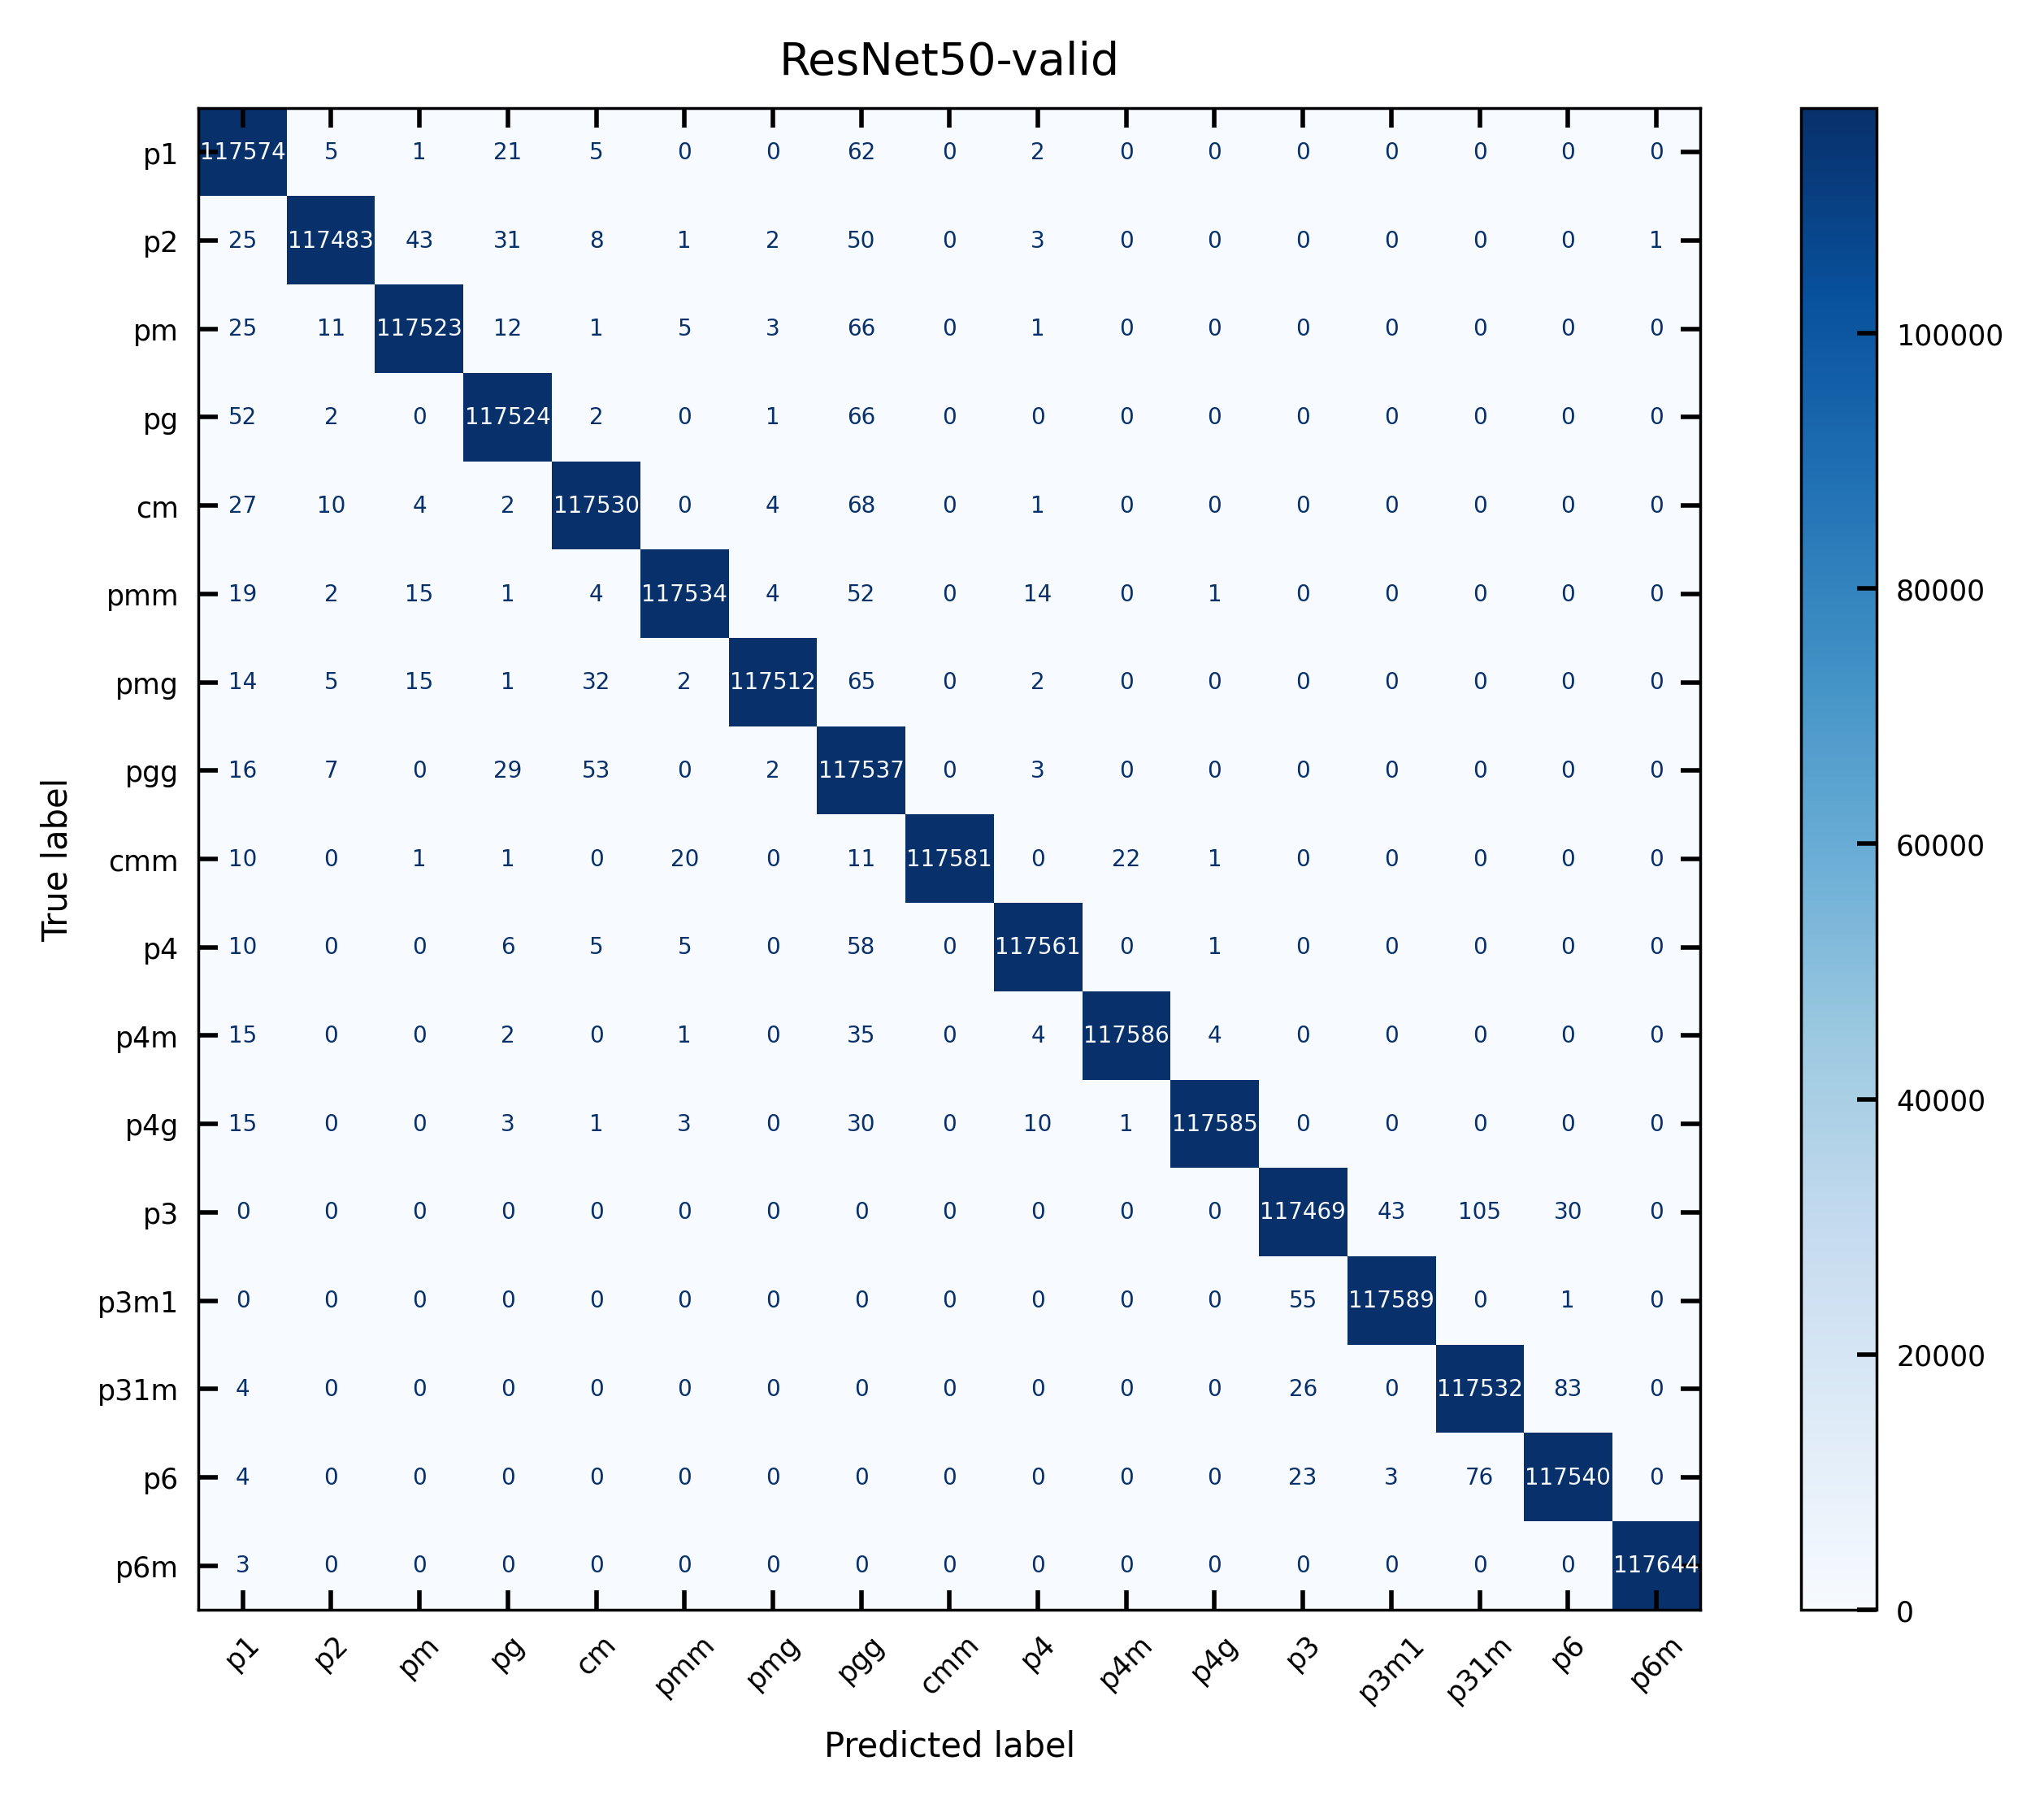

printing set for seaborn


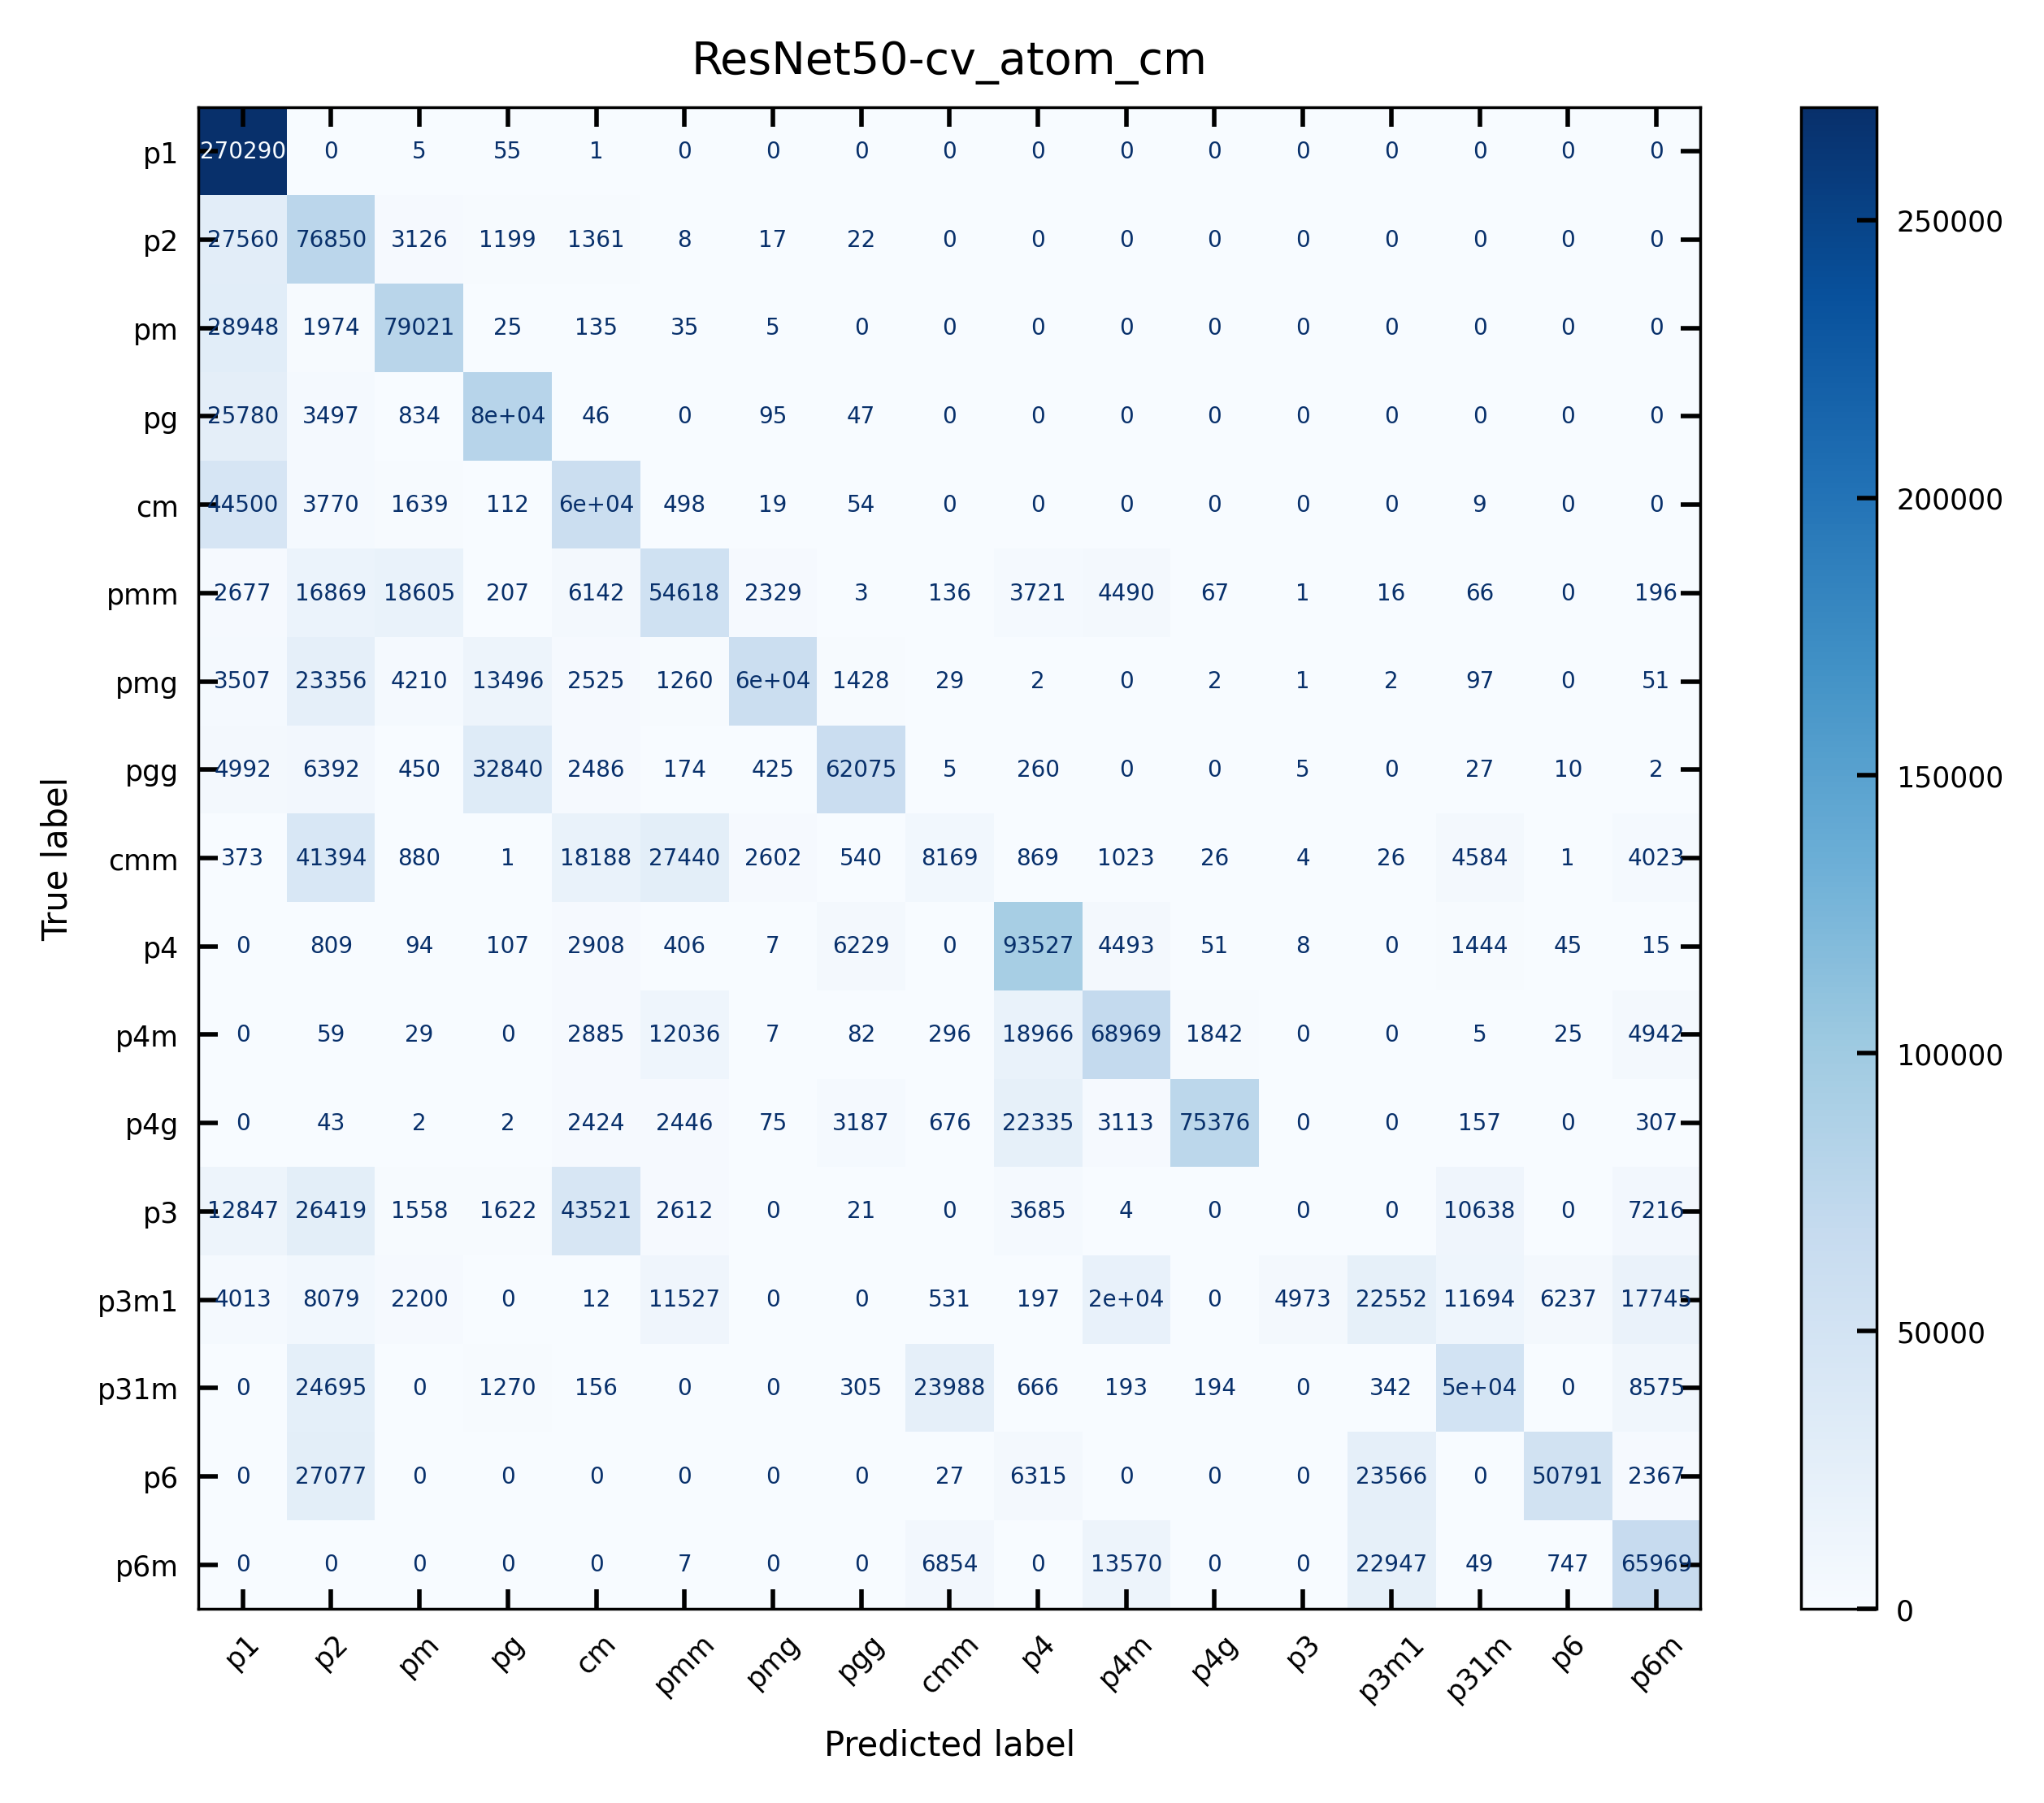

printing set for seaborn


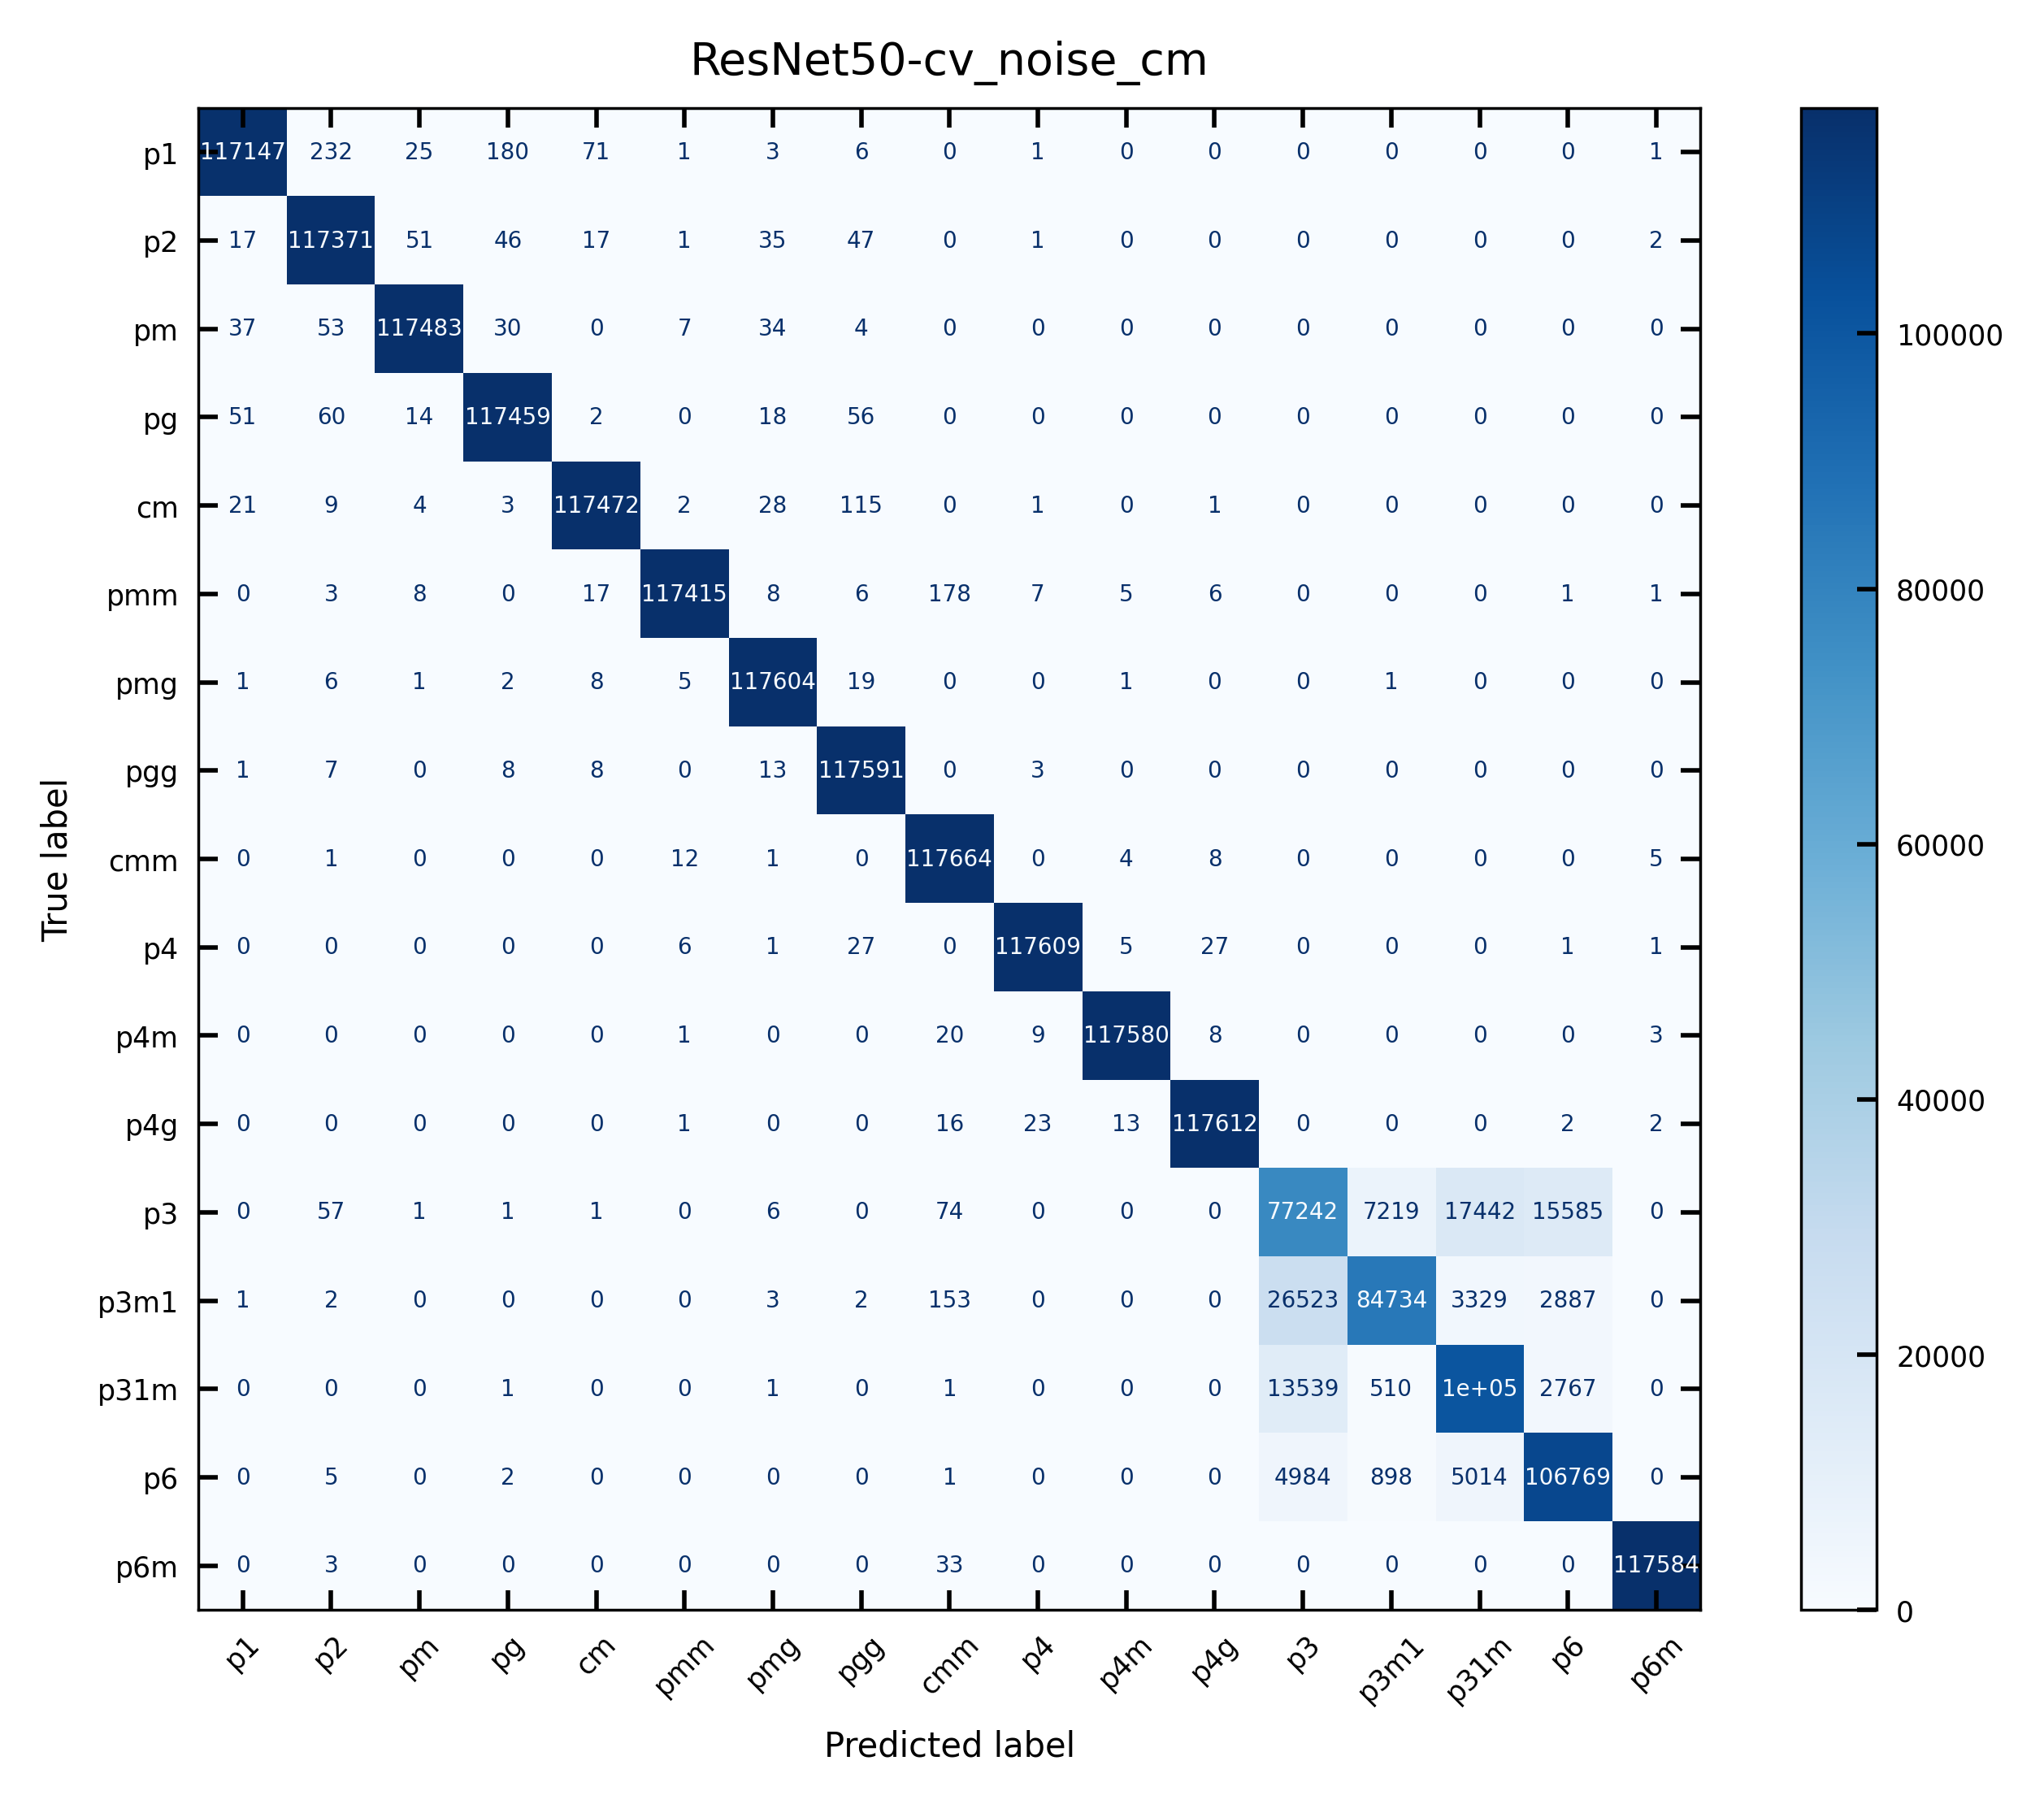

In [13]:
files = glob.glob(f'../../../saved_results/Benchmark/ResNet50/*')
keywords = ['train', 'valid', 'cv_atom_cm', 'cv_noise_cm']
show_cm(files, keywords, title_head='ResNet50-', file_path=f'../../../figures/Benchmark/ResNet50/', cm_style='simple', fig_style='printing', font_size=4)

### visualize confusions in compact layout

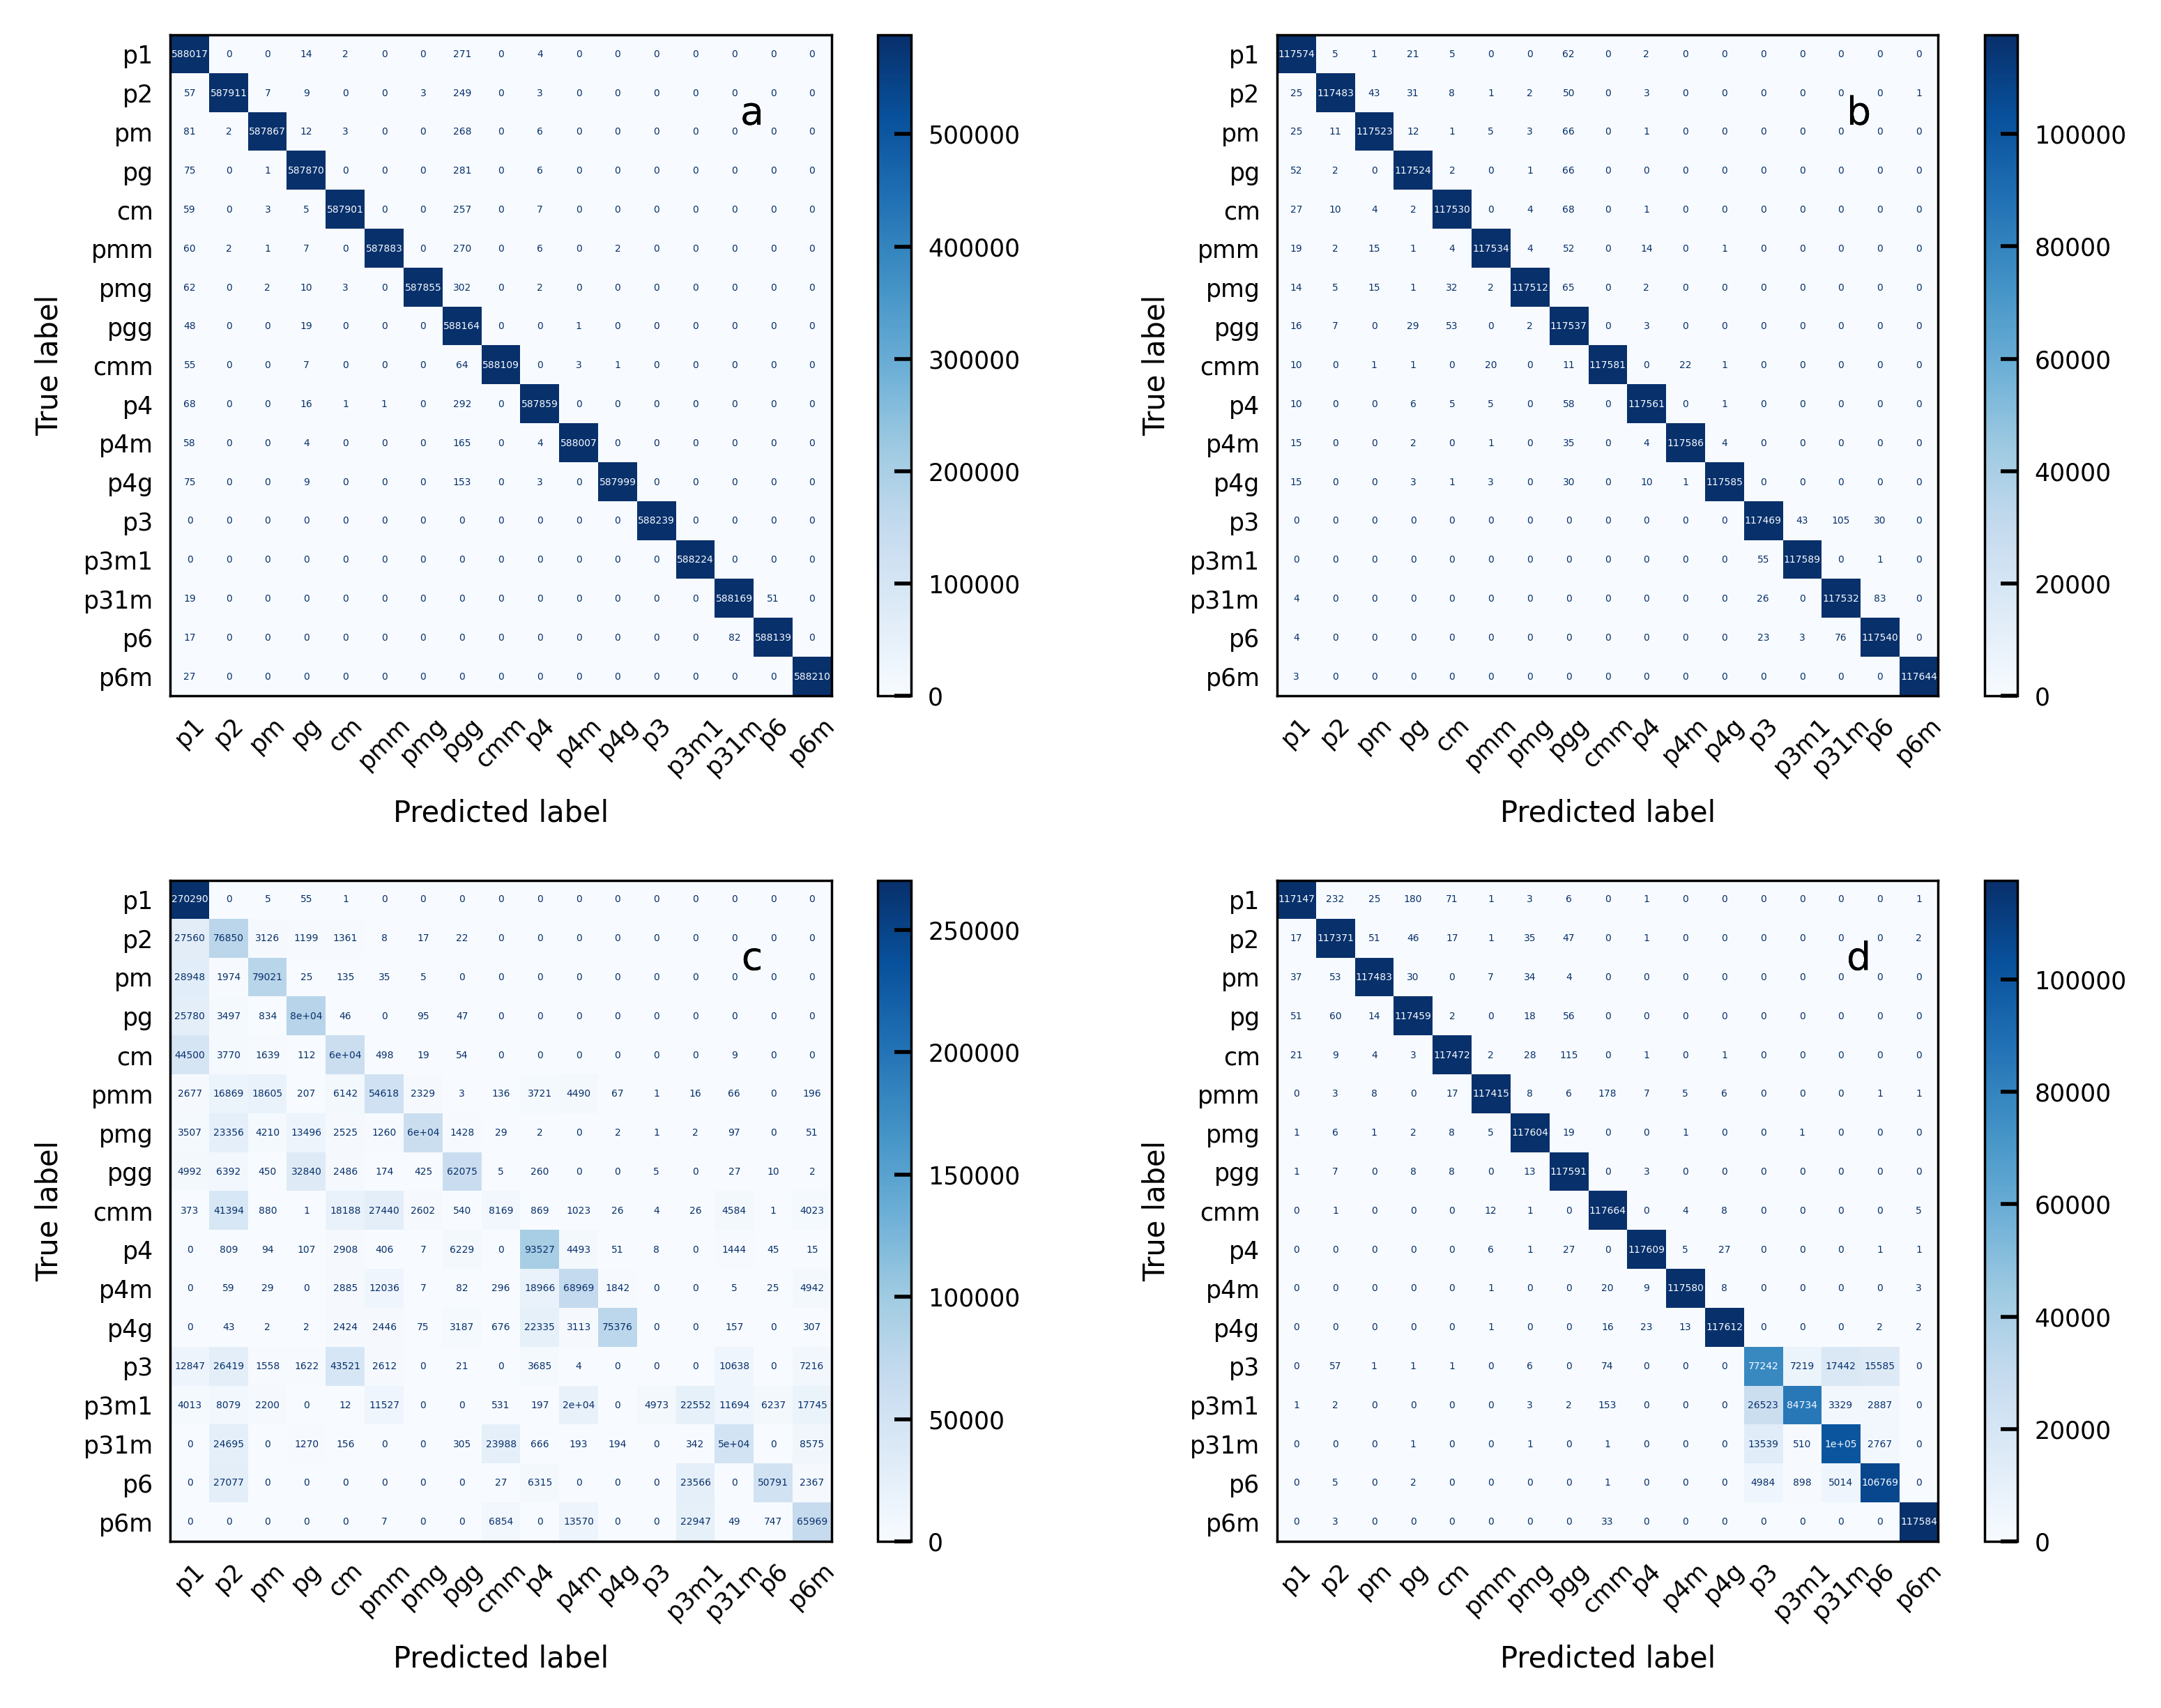

In [16]:
files = glob.glob(f'../../../saved_results/Benchmark/ResNet50/*')
keywords = ['train', 'valid', 'cv_atom_cm', 'cv_noise_cm']

show_cm(files, keywords, summary=True, title_head=None, cm_style='simple', fig_style='printing', font_size=2,
        file_path='../../../figures/Benchmark/ResNet50/Summary_cm-ResNet50')